# Advance Machine Learning

## PUBG Finish Placement Prediction

### Team Member
#### Palazzi Bruno - 806908
#### Giacomo Villa - 807462

# TO DO


# Attributes
* assists: Number of enemy players this player damaged that were killed by teammates.
* boosts: Number of boost items used.
* damageDealt: Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs: Number of enemy players knocked.
* headshotKills: Number of enemy players killed with headshots.
* heals: Number of healing items used.
* killPlace: Ranking in match of number of enemy players killed.
* killPoints: Kills-based external ranking of player.
* kills: Number of enemy players killed. 
* killStreaks: Max number of enemy players killed in a short amount of time.
* longestKill: Longest distance between player and player killed at time of death.
* matchDuration: Duration of match in seconds.
* matchType: String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches. 
* numGroups: Number of groups we have data for in the match.
* revives: Number of times this player revived teammates.
* rideDistance: Total distance traveled in vehicles measured in meters.
* roadKills: Number of kills while in a vehicle.
* swimDistance: Total distance traveled by swimming measured in meters.
* teamKills: Number of times this player killed a teammate.
* vehicleDestroys: Number of vehicles destroyed.
* walkDistance: Total distance traveled on foot measured in meters.
* weaponsAcquired: Number of weapons picked up.
* winPoints: Win-based external ranking of player. 
* maxPlace: Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements. 

# Libraries

In [10]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns

import collections

import statistics 

import numpy as np

# Function

In [85]:
def load_data():
    fields = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
             'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 
              'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
               'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']
    data = pd.read_csv('../data/dataset.csv', usecols=fields)
    # data = data['matchType' == 'squad-fpp']
    print("START DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data

def select_typology(data, typology):
    
    data = data[data.matchType == typology]
    print("SELECT TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    
    return data

def transform_task(data):
    labels = list()
    scores = data.winPlacePerc
    for score in scores:
        score = round(score, 2)
        if score >= 0 and score <= 0.2:
            labels.append(0)
        elif score >= 0.21 and score <= 0.4:
            labels.append(1)
        elif score >= 0.41 and score <= 0.6:
            labels.append(2)
        elif score >= 0.61 and score <= 0.8:
            labels.append(3)
        elif score >= 0.81 and score <= 1:
            labels.append(4)
        else:
            print("PROBLEMS VALUES: ", score)
            labels.append(-1)
    
    del data['winPlacePerc']
    
    data['label'] = labels
    
    data = data.drop(data[data.label == -1].index)
    
    print("CHANGE TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data

def print_correlation_matrix(dataset):
    corr = dataset.corr()
    plt.subplots(figsize=(15, 15))
    plot = sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values,
                      linewidths=.3, vmin=-1, vmax=1, annot=True)
    
def print_distribution(dataset):
    fig1, ax1 = plt.subplots()
    number = dataset["label"].value_counts()
    number = dict(collections.OrderedDict(sorted(number.items())))
    show = list()
    print(number)
    for value in number:
        show.append(number[value])
    print(show)
    ax1.pie(show, explode = (0, 0, 0, 0, 0.2), labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
            autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()
    
def print_kills_number(kills):
    
    plt.figure(figsize=(15,10))
    
    plt.title("Kills")
    plt.xlabel("# kills")
    plt.ylabel("times")
    
    kills_number = [0]*10
    names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
    
    for kill in kills:
        if kill >= 10:
            kills_number[9] += 1
        else:
            kills_number[kill] += 1
            
    print(kills_number)
    plt.bar(np.arange(10), height = kills_number)
    plt.show()

def print_sns_hist(value, name):
    plt.figure(figsize=(15, 10))
    value.name = name
    sns.distplot(value)
    
def print_sns_join_plot(x_value, y_value, dataset):
    sns.jointplot(x_value, y_value, typology_data, ratio=3, height=15)
    plt.show()

# Loading Data

In [3]:
data = load_data()
changed_task_data = transform_task(data)
typology_data = select_typology(changed_task_data, 'squad-fpp')

START DATASET
   assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
0        0       0         0.00      0              0      0         60   
1        0       0        91.47      0              0      0         57   
2        1       0        68.00      0              0      0         47   
3        0       0        32.90      0              0      0         75   
4        0       0       100.00      0              0      0         45   

   killPoints  kills  killStreaks  ...  revives  rideDistance roadKills  \
0        1241      0            0  ...        0        0.0000         0   
1           0      0            0  ...        0        0.0045         0   
2           0      0            0  ...        0        0.0000         0   
3           0      0            0  ...        0        0.0000         0   
4           0      1            1  ...        0        0.0000         0   

   swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
0     

# Data Analysis

In [ ]:
print_correlation_matrix(typology_data)

In [ ]:
print_distribution(typology_data)

### Kills 

In [40]:
avg_kill = statistics.mean(typology_data.kills)
print("{:<25}{:>5}".format("AVERAGE KILLS IN A MATCH:", round(avg_kill, 3)))

AVERAGE KILLS IN A MATCH:0.908


[997788, 373523, 181805, 94162, 49023, 26026, 14439, 8285, 4707, 6428]


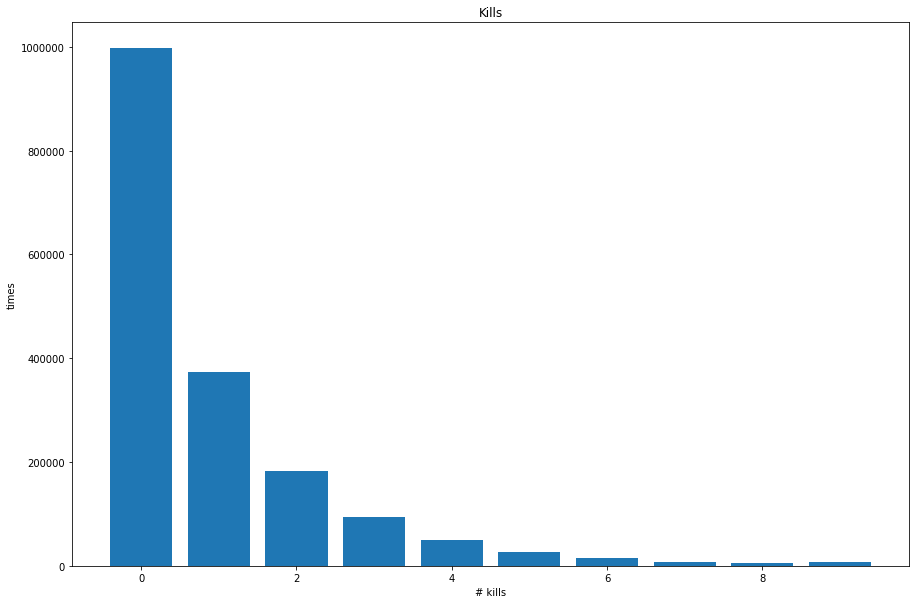

In [86]:
print_kills_number(typology_data.kills)

### Walk

In [35]:
print("{:<20}{:>6}".format("PLAYERS DIED IMMEDIATELY:",len(typology_data[typology_data.walkDistance == 0])))

PLAYERS DIED IMMEDIATELY: 30079


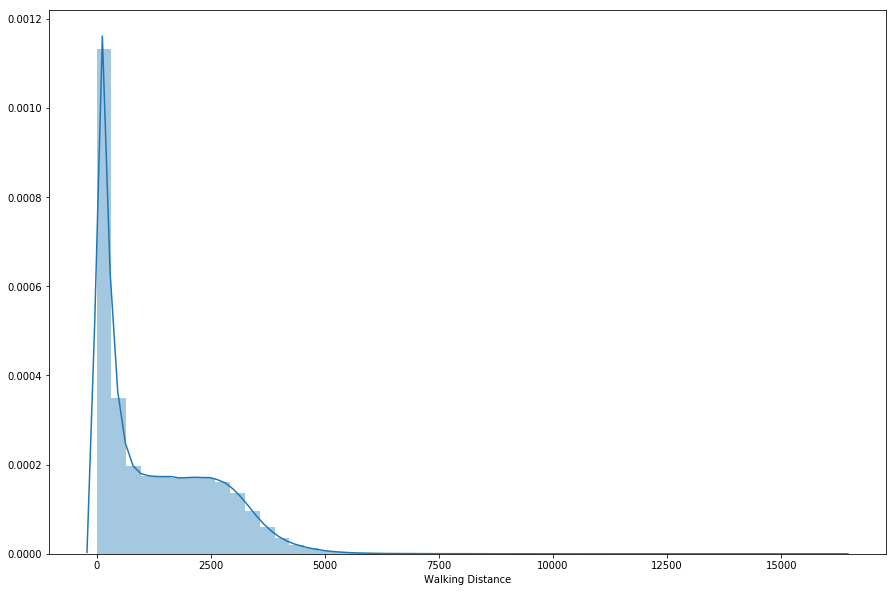

In [57]:
print_sns_hist(typology_data.walkDistance, "Walking Distance")

### Damage

In [56]:
avg_damage = statistics.mean(typology_data.damageDealt)
print("{:<25}{:>5}".format("AVERAGE DAMAGE IN A MATCH: ", round(avg_damage, 3)))

AVERAGE DAMAGE IN A MATCH: 133.588


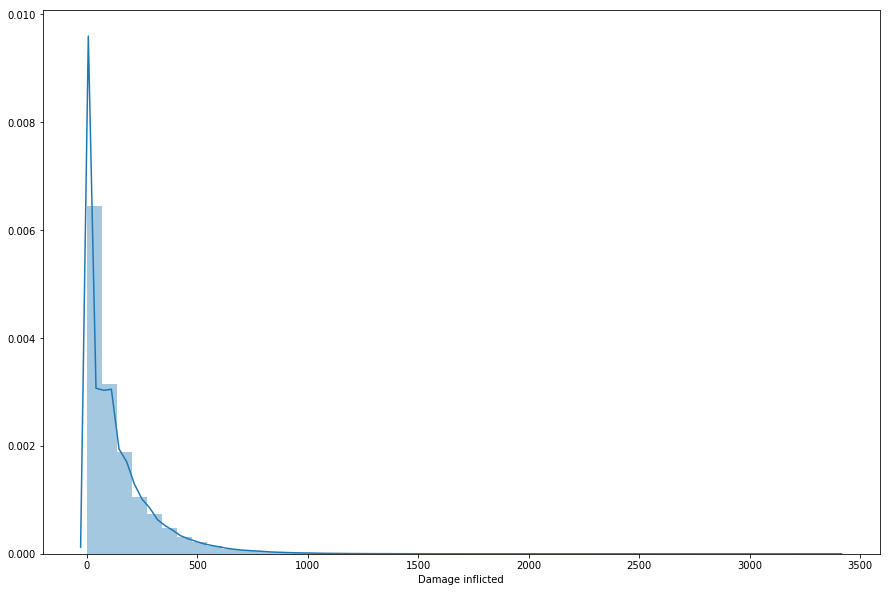

In [58]:
print_sns_hist(typology_data.damageDealt, "Damage inflicted")

### Walking x Damage

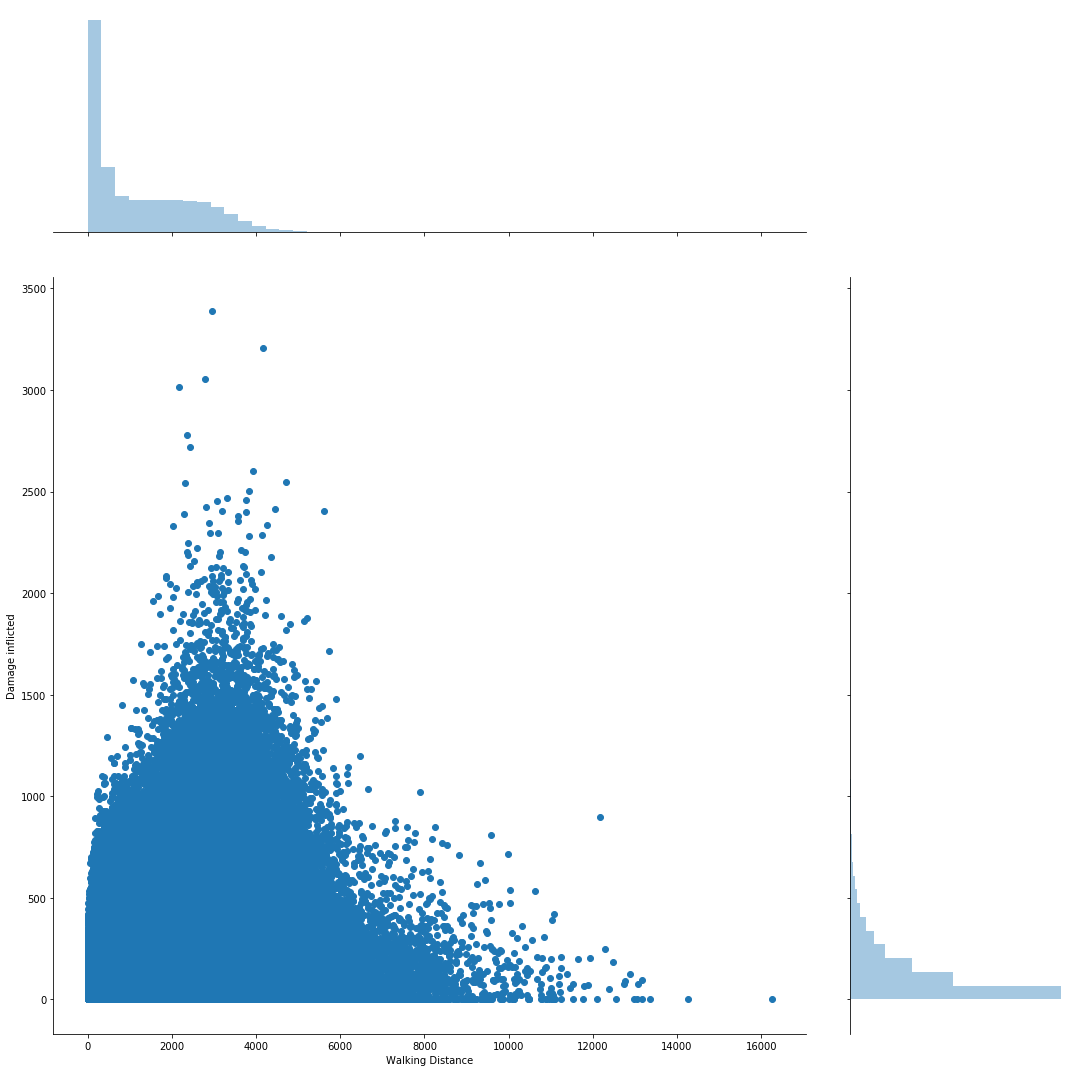

In [67]:
print_sns_join_plot("walkDistance", "damageDealt", typology_data)

### Walking x Kills

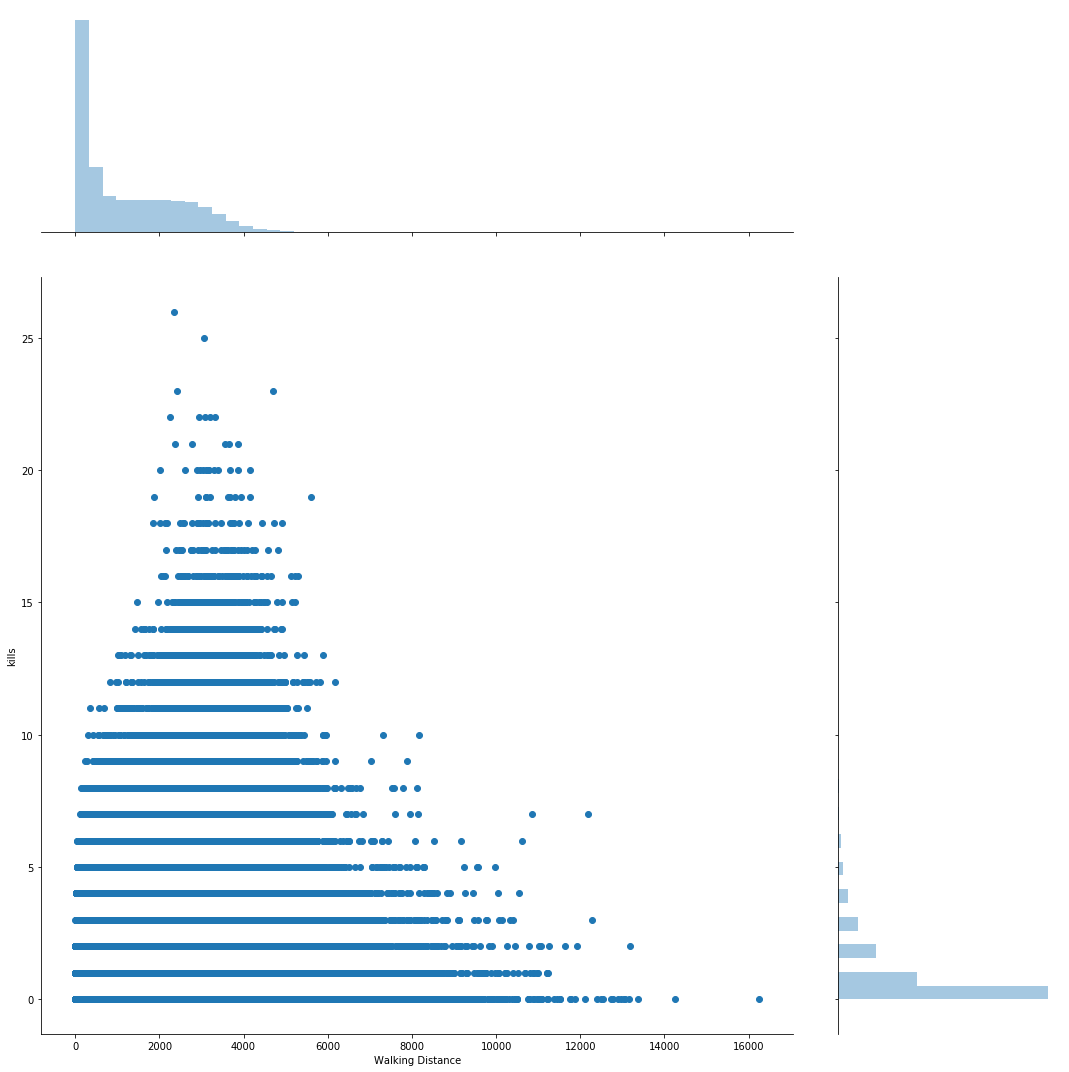

In [68]:
print_sns_join_plot("walkDistance", "kills", typology_data)

### Damage x Kills

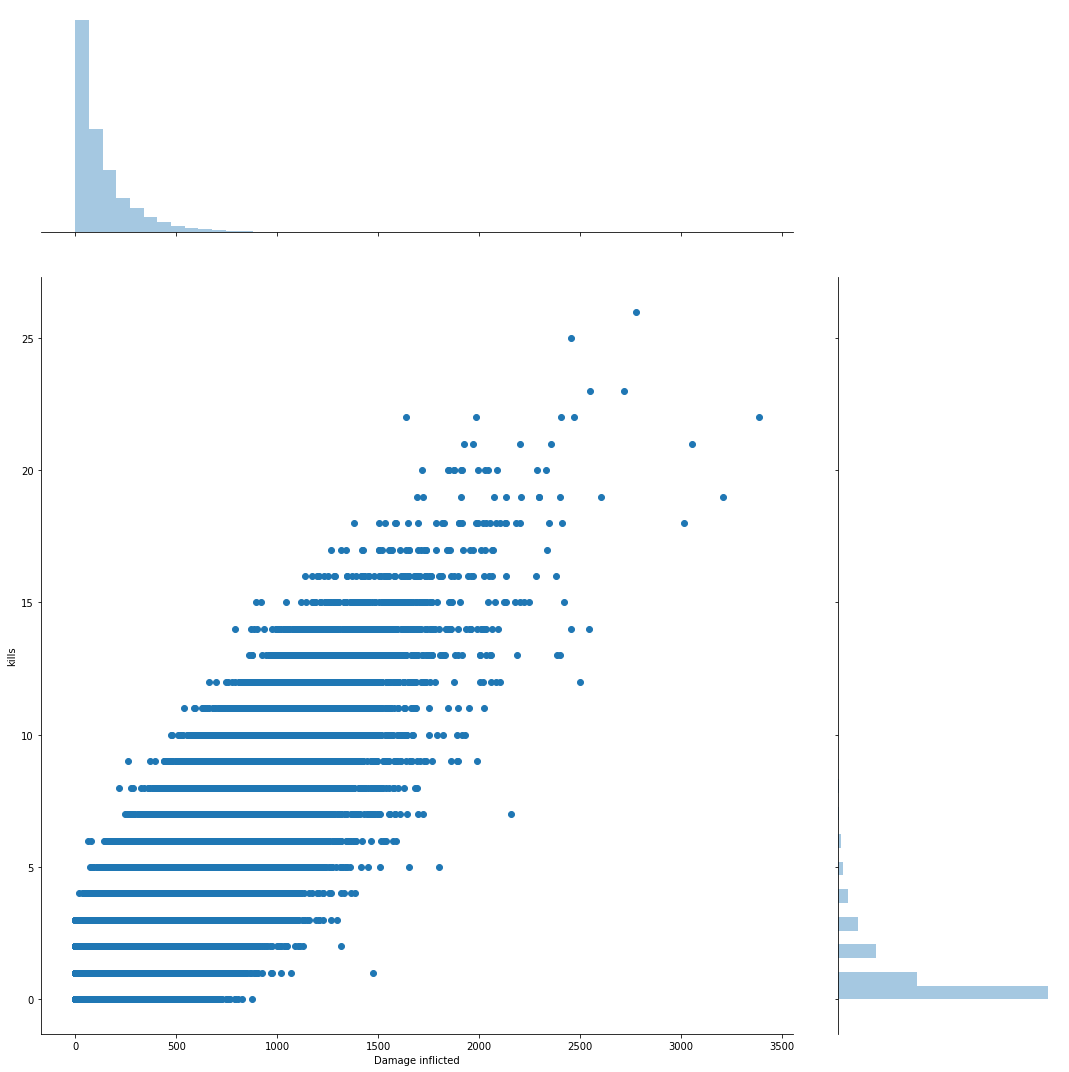

In [69]:
print_sns_join_plot("damageDealt", "kills", typology_data)

### High class study

In [72]:
high = typology_data[typology_data.label == 4]

In [78]:
avg_kill = statistics.mean(high.kills)
print("{:<32}{:>5}".format("AVERAGE KILLS FOR PRO PLAYERS:", round(avg_kill, 3)))
print("{:<32}{:>5}".format("MAX KILLS BY PRO PLAYES:", max(high.kills)))
print("{:<32}{:>5}".format("MIN KILLS BY PRO PLAYES:", min(high.kills)))

AVERAGE KILLS FOR PRO PLAYERS:  1.998
MAX KILLS BY PRO PLAYES:           26
MIN KILLS BY PRO PLAYES:            0


[102593, 78095, 57597, 39458, 25766, 16291, 10144, 6270, 3789, 5652]


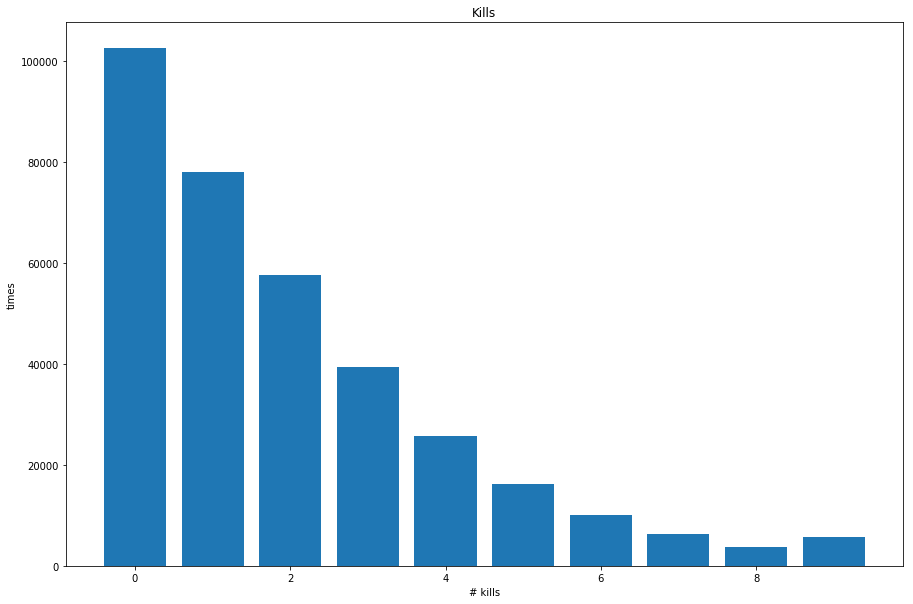

In [87]:
print_kills_number(high.kills)

# Optimization

10


TypeError: object of type 'function' has no len()

# Performance Analysis